
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# To ease the loading of modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load BEACS module
from beacs.agents.beacs import BEACS, Configuration

# Load Metrics
from example.metrics.MazeMetrics import \
    _maze_metrics, \
    _how_many_peps_match_non_aliased_states, \
    _mean_reliable_classifier_specificity, \
    _when_full_knowledge_is_achieved, \
    _enhanced_effect_error

# Load Plotting Wrappers
from example.metrics.MazePlottingWrapper import \
    parse_metrics_to_df, \
    plot_performance

# Load environments
import gym
import my_mazes

# Agent - BEACS

## Common parameters

In [2]:
#Environmental Set Up
RANDOM_ATTRIBUTE_LENGTH = 0
CLASSIFIER_LENGTH = 8 + RANDOM_ATTRIBUTE_LENGTH
NUMBER_OF_POSSIBLE_ACTIONS = 8
SLIPPERY_PROB = 0.
MAZE = "MazeE2-v0"

#Exploration Set Up
NUMBER_OF_EXPLORE_TRIALS = 5000
METRICS_TRIAL_FREQUENCY_EXPLORE = 100
EPSILON = 0.8
BETA_ALP = 0.05

#Exploitation Set Up
NUMBER_OF_EXPLOIT_TRIALS_NO_RL = 500
BETA_EXPLOIT_NO_RL = 0.05
NUMBER_OF_EXPLOIT_TRIALS_RL_START = 500
BETA_EXPLOIT_RL_START = 0.05
NUMBER_OF_EXPLOIT_TRIALS_RL = 500
BETA_EXPLOIT_RL = 0.05

#RL Set Up
GAMMA = 0.95
BETA_RL = 0.05

#GA Set Up
CROSSOVER = 0.8
MUTATION = 0.3

#BEACS Set Up
DO_ZIP = True
ENABLE_PEP = True
LENGTH_OF_BEHAVIORAL_SEQUENCES = 2

## Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Set up probability to do a random action
maze.env.set_prob_slippery(SLIPPERY_PROB)
# Set up random attribute length
maze.env.set_random_attribute_length(RANDOM_ATTRIBUTE_LENGTH)
# Reset it, by putting an agent into random position
maze.reset()
# Render the state in ASCII
maze.render('aliasing_human')
# Get environmental state transitions
#maze.env.get_theoritical_probabilities()


■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ ■ ■ ■ ■ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■
■ ■ ■ □ □ □ ■ ■ ■
■ ■ ■ □ $ □ ■ ■ ■
■ ■ ■ □ □ □ ■ ■ ■
■ ■ ■ ■ ■ A ■ ■ ■
■ □ ■ ■ ■ ■ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■


## Training of BEACS - Exploration

In [4]:
%%time
#%%prun -l 0.5 -T profiling.txt

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_pep=ENABLE_PEP,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    gamma=GAMMA,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    mu=MUTATION,
    chi=CROSSOVER,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 28min 51s, sys: 10.1 s, total: 29min 1s
Wall time: 29min 37s


### Performance

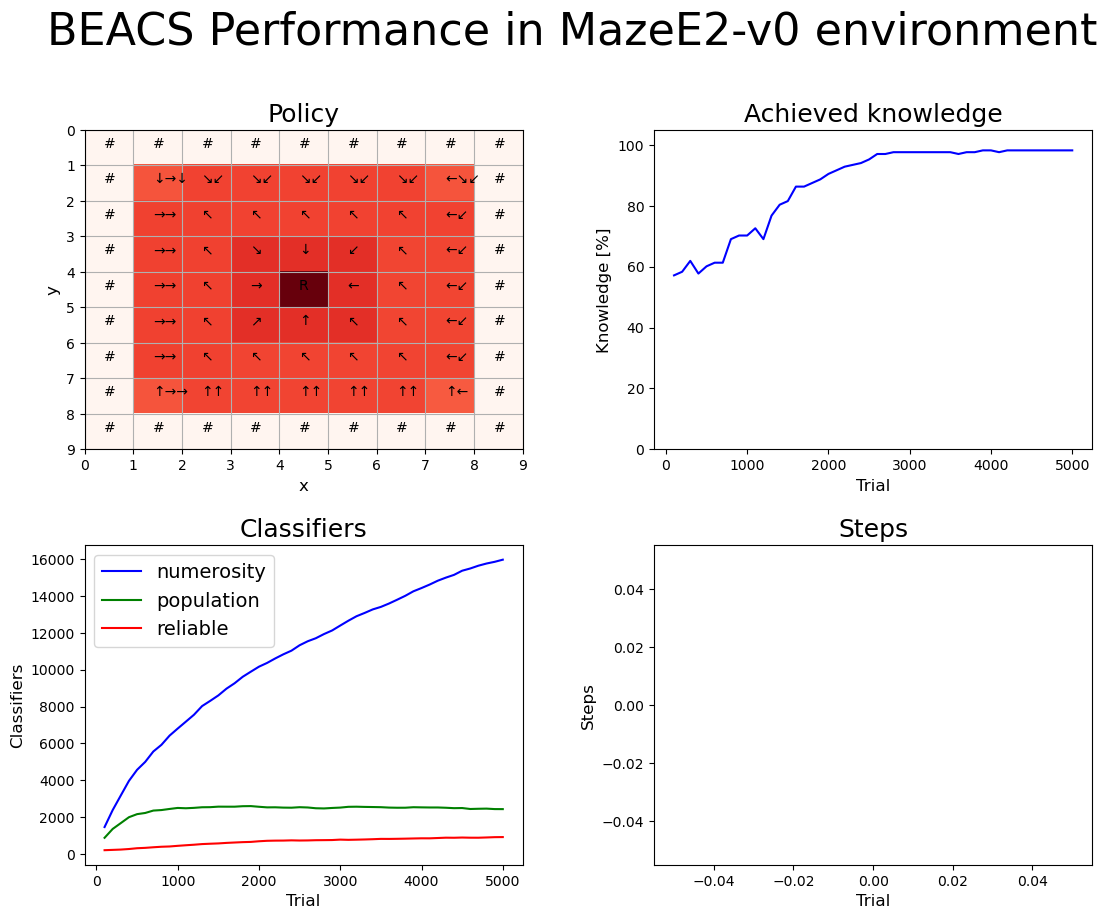

In [5]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_performance(agent_explore, maze, metrics_df, cfg_explore, MAZE, metrics_trial_frequency_explore, None)

In [6]:
first_trial, stable_trial, last_trial = _when_full_knowledge_is_achieved(metrics_explore)
print("Full knowledge was achieved at trials ", first_trial, ", was stable at ", stable_trial, 
        " and the last time it was achieved at ", last_trial)

print("There are ", _how_many_peps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.\n")

print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))
pep_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities :", pep_error, "%\n")

if DO_ZIP:
    agent_explore.zip_population()
    population_explore = agent_explore.get_population()

print("There are ", _how_many_peps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.\n")

print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))
pep_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities :", pep_error, "%")

Full knowledge was achieved at trials  -1 , was stable at  -1  and the last time it was achieved at  -1
There are  0  enhanced classifer(s) that match a non-aliased states.

{'knowledge': 98.21428571428571, 'population': 2433, 'numerosity': 15968, 'reliable': 916}
Mean reliable population specifity is  0.6905021834061136
Accumulated Error on PEP Probabilities : 1.2326963544728038 %

There are  0  enhanced classifer(s) that match a non-aliased states.

{'knowledge': 98.21428571428571, 'population': 602, 'numerosity': 8684, 'reliable': 552}
Mean reliable population specifity is  0.6055253623188406
Accumulated Error on PEP Probabilities : 1.0650934605146634 %


In [7]:
population_explore.sort(key=lambda cl: -cl.fitness)
population_explore_to_display = [cl for cl in population_explore]
for cl in population_explore_to_display:
    print(cl)
    print("\n")

###9#### 3 None (###0####:#562)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 0.005883
exp: 507   num: 15 ee: False
Mark: empty Aliased_state:  PAI_state: 
tga: 162163 tbseq: 156234 talp: 162163 tav: 304.3  



##9##### 2 None (##0#####:#542)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 0.007786
exp: 492   num: 14 ee: False
Mark: empty Aliased_state:  PAI_state: 
tga: 162175 tbseq: 1145  talp: 162184 tav: 345.1  



#9###### 1 None (#0######:#547)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 0.006164
exp: 498   num: 20 ee: False
Mark: empty Aliased_state:  PAI_state: 
tga: 162468 tbseq: 155480 talp: 162468 tav: 456.3  



9####### 0 None (0#######:#541)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 0.007389
exp: 490   num: 18 ee: False
Mark: empty Aliased_state:  PAI_state: 
tga: 162516 tbseq: 3     talp: 162516 tav: 408.2  



#######9 7 None (#######0:#523)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 0.01131
exp: 475   n



###9#### 7 [2] (###0####:#32)
q: 0.9477 ra: 505.3  rb: 402.8  ir: 0.0    f: 430.3  err: 376.5 
exp: 32    num: 20 ee: False
Mark: empty Aliased_state:  PAI_state: 00000000
tga: 156884 tbseq: 4732  talp: 156884 tav: 4.951e+03 



00000090 0 [0] (######0#:#37)
q: 0.9539 ra: 449.1  rb: 450.7  ir: 0.0    f: 429.2  err: 390.5 
exp: 35    num: 20 ee: False
Mark: empty Aliased_state:  PAI_state: 00000000
tga: 159294 tbseq: 4576  talp: 159294 tav: 4.569e+03 



###90### 0 [1] (11#0###1:#23)
q: 0.939  ra: 472.2  rb: 438.7  ir: 0.0    f: 427.6  err: 331.1 
exp: 23    num: 20 ee: False
Mark: empty Aliased_state:  PAI_state: 00000000
tga: 160066 tbseq: 14912 talp: 160066 tav: 6.345e+03 



######90 3 [2, 1] (#111##0#:#35)
q: 0.917  ra: 497.4  rb: 460.8  ir: 0.0    f: 422.6  err: 389.9 
exp: 35    num: 20 ee: False
Mark: empty Aliased_state:  PAI_state: 00000000
tga: 156741 tbseq: 4632  talp: 156741 tav: 4.629e+03 



1####11# 2 None (#####00#:#61)
q: 0.9359 ra: 449.4  rb: 303.9  ir: 0.0    f: 42

In [8]:
agent_explore.get_pai_states_memory()

[('0', '1', '1', '1', '0', '0', '0', '0'),
 ('0', '0', '0', '0', '0', '0', '0', '0'),
 ('1', '1', '0', '0', '0', '0', '0', '1'),
 ('0', '0', '0', '0', '0', '1', '1', '1'),
 ('0', '0', '0', '1', '1', '1', '0', '0')]

## Training of BEACS - Exploitation

In [9]:
%%time

cfg_exploit_no_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_NO_RL,
    gamma=GAMMA,
    epsilon=0.2
)

agent_exploit_no_rl = BEACS(cfg_exploit_no_rl, population_explore)
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_NO_RL)

CPU times: user 16.8 s, sys: 82.5 ms, total: 16.9 s
Wall time: 17.2 s


In [10]:
%%time

cfg_exploit_rl_start = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_RL_START,
    gamma=GAMMA,
    epsilon=0.0
)

agent_exploit_rl_start = BEACS(cfg_exploit_rl_start, population_exploit_no_rl)
population_exploit_rl_start, metrics_exploit_rl_start = agent_exploit_rl_start.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL_START)

CPU times: user 15.4 s, sys: 50.4 ms, total: 15.4 s
Wall time: 15.5 s


In [11]:
%%time

cfg_exploit_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_RL,
    gamma=GAMMA,
    epsilon=0.0,
)

agent_exploit_rl = BEACS(cfg_exploit_rl, population_exploit_rl_start)
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 15.6 s, sys: 69 ms, total: 15.7 s
Wall time: 16 s


### Performance

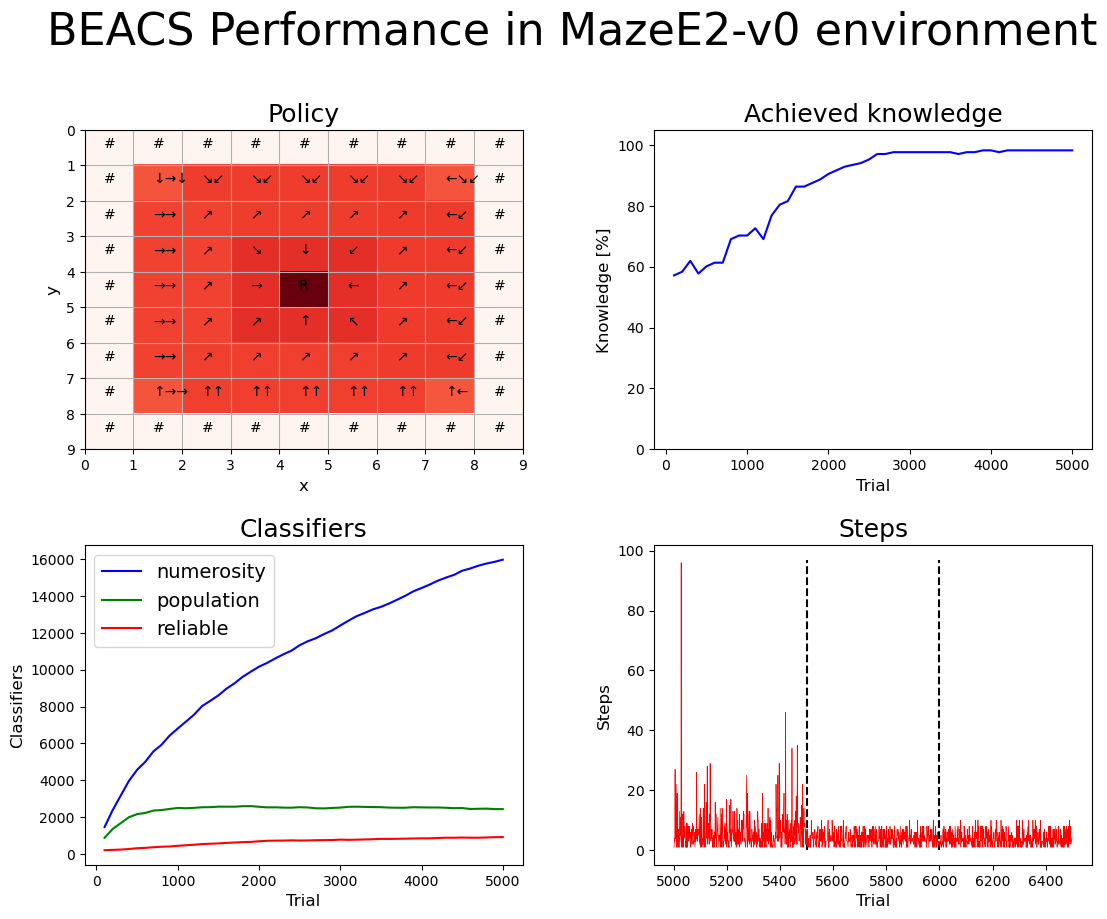

In [12]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    metrics_exploit.append(tmp)
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL + NUMBER_OF_EXPLOIT_TRIALS_RL_START
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit, metrics_trial_frequency_exploit)
plot_performance(agent_exploit_rl, maze, metrics_df, cfg_exploit_rl, MAZE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_NO_RL,NUMBER_OF_EXPLOIT_TRIALS_RL_START,NUMBER_OF_EXPLOIT_TRIALS_RL])

In [13]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / metrics_trial_frequency_explore
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

avg_step_exploit_no_rl = 0
for trial in metrics_exploit_no_rl:
    avg_step_exploit_no_rl += trial['steps_in_trial']
avg_step_exploit_no_rl /= NUMBER_OF_EXPLOIT_TRIALS_NO_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_no_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_NO_RL, " trials in EXPLOITATION without Reinforcement Module")

avg_step_exploit_rl_start = 0
for trial in metrics_exploit_rl_start:
    avg_step_exploit_rl_start += trial['steps_in_trial']
avg_step_exploit_rl_start /= NUMBER_OF_EXPLOIT_TRIALS_RL_START
print("Average number of steps to solve the maze is ",avg_step_exploit_rl_start,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL_START, " trials in EXPLOITATION starting Reinforcement Module")

avg_step_exploit_rl = 0
for trial in metrics_exploit_rl:
    avg_step_exploit_rl += trial['steps_in_trial']
avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")

print(_maze_metrics(population_explore, maze))
print(_maze_metrics(population_exploit_no_rl, maze))
print(_maze_metrics(population_exploit_rl_start, maze))
print(_maze_metrics(population_exploit_rl, maze))

Average number of steps to solve the maze is  36.96  for a total of  5000  trials in EXPLORATION
Average number of steps to solve the maze is  6.26  for a total of  500  trials in EXPLOITATION without Reinforcement Module
Average number of steps to solve the maze is  3.93  for a total of  500  trials in EXPLOITATION starting Reinforcement Module
Average number of steps to solve the maze is  3.858  for a total of  500  trials in EXPLOITATION with Reinforcement Module
{'knowledge': 98.21428571428571, 'population': 602, 'numerosity': 8684, 'reliable': 552}
{'knowledge': 98.21428571428571, 'population': 602, 'numerosity': 8684, 'reliable': 552}
{'knowledge': 98.21428571428571, 'population': 602, 'numerosity': 8684, 'reliable': 552}
{'knowledge': 98.21428571428571, 'population': 602, 'numerosity': 8684, 'reliable': 552}


In [14]:
population_exploit_rl.sort(key=lambda cl: -cl.fitness)
population_exploit_rl_to_display = [cl for cl in population_exploit_rl
    if cl.behavioral_sequence]
print(len(population_exploit_rl_to_display))
print("\n")
for cl in population_exploit_rl_to_display:
    print(cl)
    print("\n")

398


#1110000 6 [5] (#00#11##:#216, #000####:#270, #000#9##:#218, #000###9:#238, #000##9#:#198)
q: 1.0    ra: 933.8  rb: 935.0  ir: 0.0    f: 934.4  err: 27.88 
exp: 1125  num: 20 ee: False
Mark: empty Aliased_state: 01110000 PAI_state: 00000000
tga: 162593 tbseq: 13636 talp: 162593 tav: 130.3  



11#00001 3 [5] (00#####0:#394, 00#9###0:#268, 00###9#0:#226, 00##9##0:#297)
q: 1.0    ra: 925.5  rb: 931.5  ir: 0.0    f: 928.5  err: 35.32 
exp: 1176  num: 20 ee: False
Mark: empty Aliased_state: 11000001 PAI_state: 00000000
tga: 162560 tbseq: 8264  talp: 162560 tav: 90.45  



0#0111#0 0 [0] (#9#000##:#382, ###000#9:#293, ###000##:#623, 9##000##:#339)
q: 1.0    ra: 913.0  rb: 916.3  ir: 0.0    f: 914.7  err: 47.86 
exp: 1619  num: 20 ee: False
Mark: empty Aliased_state: 00011100 PAI_state: 00000000
tga: 162358 tbseq: 6490  talp: 162358 tav: 119.7  



#000#1#1 2 [2] (#####000:#646, ##9##000:#319, ###9#000:#282, #9###000:#328)
q: 1.0    ra: 907.1  rb: 903.7  ir: 0.0    f: 905.4  err: 53.27